In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv',sep=';')

#### Which wells have missing Z_LOC data?

In [3]:
df.WELL[~df.Z_LOC.notna()].unique()

array(['16/10-5', '16/11-1 ST3', '16/2-11 A', '25/5-4', '25/8-7',
       '31/3-1', '31/5-4 S', '32/2-1', '34/2-4', '35/11-6', '36/7-3',
       '7/1-1', '7/1-2 S'], dtype=object)

#### How much missing Z_LOC data?

In [4]:
for w in df.WELL[~df.Z_LOC.notna()].unique():
    mi = len(df[df.WELL==w][~df.Z_LOC.notna()])
    pr = len(df[df.WELL==w])
    print(f'{w:>15}: no of missing Z_LOC points = {mi:>4d} (or {100*(mi/pr):>4.1f}% of all points)')

/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


        16/10-5: no of missing Z_LOC points =   10 (or  0.4% of all points)
    16/11-1 ST3: no of missing Z_LOC points = 7374 (or 49.4% of all points)
      16/2-11 A: no of missing Z_LOC points =    9 (or  0.1% of all points)
         25/5-4: no of missing Z_LOC points =    7 (or  0.1% of all points)
         25/8-7: no of missing Z_LOC points =  355 (or  3.9% of all points)
         31/3-1: no of missing Z_LOC points =  463 (or  3.5% of all points)
       31/5-4 S: no of missing Z_LOC points = 1791 (or 15.8% of all points)
         32/2-1: no of missing Z_LOC points =    8 (or  0.3% of all points)
         34/2-4: no of missing Z_LOC points =   16 (or  0.1% of all points)
        35/11-6: no of missing Z_LOC points =  528 (or  2.2% of all points)
         36/7-3: no of missing Z_LOC points =    3 (or  0.1% of all points)
          7/1-1: no of missing Z_LOC points =  203 (or  1.2% of all points)
        7/1-2 S: no of missing Z_LOC points =    8 (or  0.4% of all points)


#### Visualise where Z_LOC is missing

/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently us

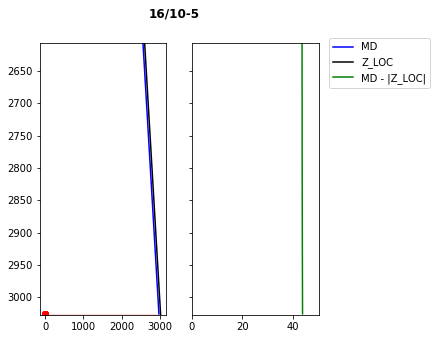

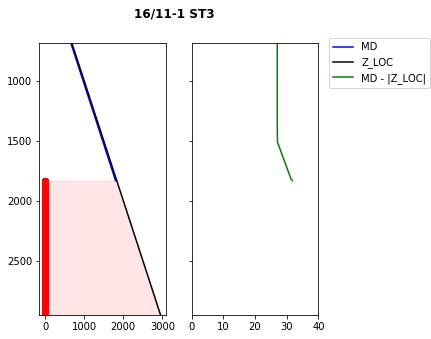

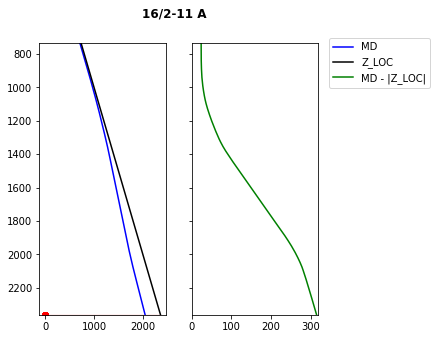

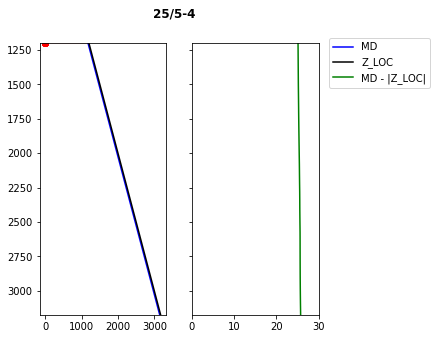

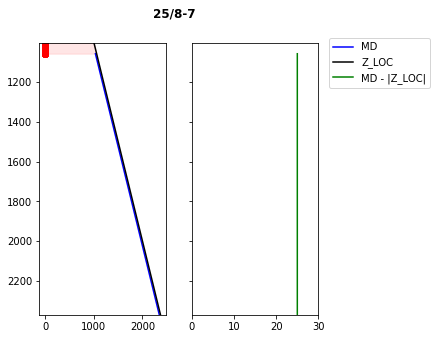

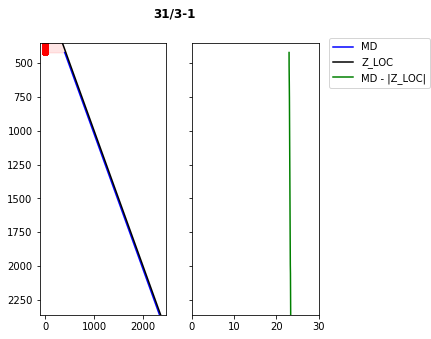

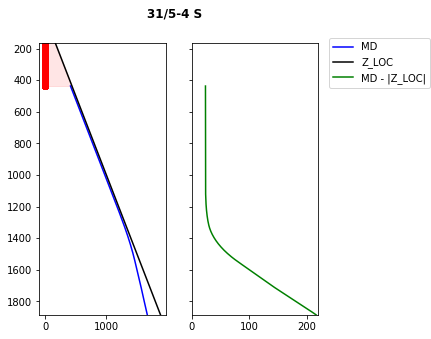

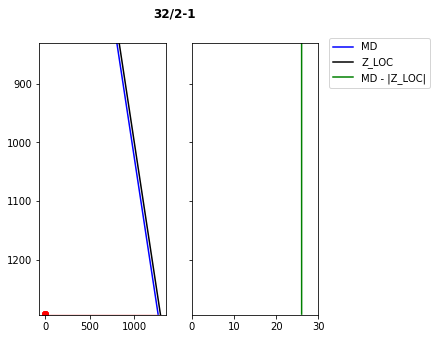

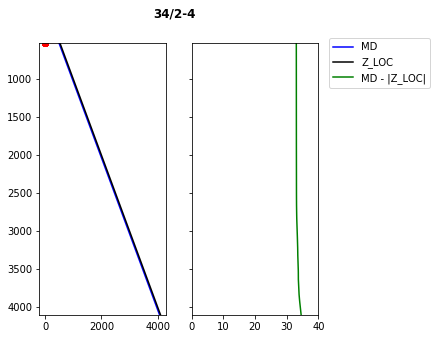

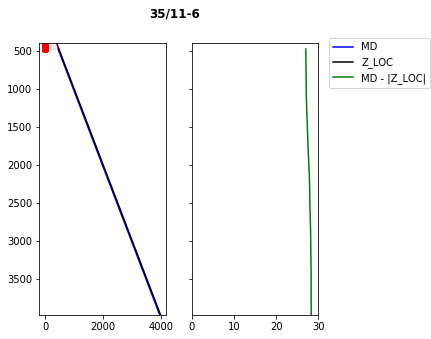

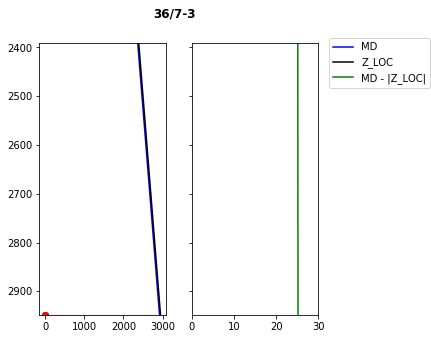

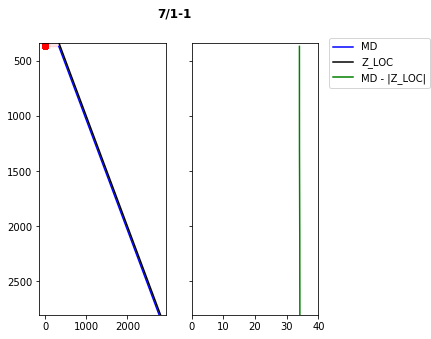

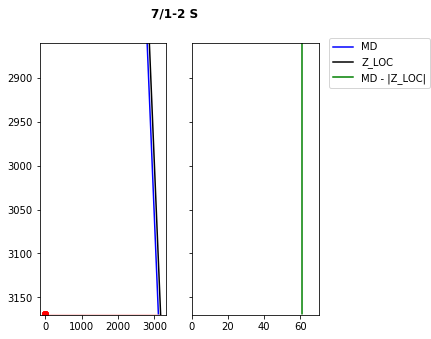

In [5]:
for w in df.WELL[~df.Z_LOC.notna()].unique():
    data = df.loc[:,['DEPTH_MD', 'Z_LOC']][df.WELL==w]

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5,5), sharey=True)

    ax[0].plot(-data.Z_LOC, data.DEPTH_MD, 'b-',label='MD')
    ax[0].plot(data.DEPTH_MD, data.DEPTH_MD, 'k-', label='Z_LOC')
    ax[0].plot(np.linspace(0,0,len(data.DEPTH_MD[data.Z_LOC.isna()])),data.DEPTH_MD[data.Z_LOC.isna()],'ro')
    ax[0].fill_betweenx(data.DEPTH_MD, 0, data.DEPTH_MD, where=data.Z_LOC.isna(), color='red', alpha=0.1)
    ax[0].set_ylim([max(data.DEPTH_MD), min(data.DEPTH_MD)])
    
    ax[1].plot(data.DEPTH_MD+data.Z_LOC, data.DEPTH_MD,'g-', label='MD - |Z_LOC|')
    try:
        ax[1].set_xlim([0,max(((data.DEPTH_MD+data.Z_LOC).dropna()/10).apply(math.ceil)*10)])
    except:
        pass    

    fig.legend( bbox_to_anchor=(0.9, 0.85), loc='upper left')
    fig.suptitle(w,fontweight='bold')
    fig.show()

#### So Z_LOC data is never missing "in the middle": it is either at the top of the well, or the base. Moreover, for virtually all wells, there is just a small interval of data missing.
#### We can see from the plots that all wells apart from 16/11-1 ST3 and 16/2-11 A are vertical in the section where Z_LOC is missing. This makes it easy, as -Z_LOC = DEPTH_MD - [constant] for all but these two wells. Get this constant close to the interval where Z_LOC is missing (as the well might be deviated in another section). 


#### Well 16/11-1 ST3 is problematic well: it is both deviated and misses Z_LOC data in approximately the lower half of the well.

In [6]:
# well list in three parts:
#   - first row are the wells that are missing Z_LOC data at the top of the entire interval covered by the well
#   - second row are the wells that are missing Z_LOC data at the base of the entire interval covered by the well
#   - third row are special/problematic wells
vertical_wells_fix_Z_LOC = ['25/5-4', '25/8-7', '31/3-1', '31/5-4 S', '34/2-4', '35/11-6', '7/1-1',
                            '16/10-5', '32/2-1', '36/7-3', '7/1-2 S',
                            '16/11-1 ST3', '16/2-11 A']

for w in vertical_wells_fix_Z_LOC:
    print(f'indices missing Z_LOC in well {w:>11}: {min(df[df.WELL==w][df.Z_LOC.isna()].index):7d}\
-{max(df[df.WELL==w][df.Z_LOC.isna()].index):7d}  (=\
{max(df[df.WELL==w][df.Z_LOC.isna()].index)-min(df[df.WELL==w][df.Z_LOC.isna()].index):4d} indcs)\
 --> {df.loc[min(df[df.WELL==w][df.Z_LOC.isna()].index),"DEPTH_MD"]:8.3f}-\
{df.loc[max(df[df.WELL==w][df.Z_LOC.isna()].index),"DEPTH_MD"]:8.3f} mMD\
 (={df.loc[max(df[df.WELL==w][df.Z_LOC.isna()].index),"DEPTH_MD"]-df.loc[min(df[df.WELL==w][df.Z_LOC.isna()].index),"DEPTH_MD"]:8.3f} mMD)')
    if w == '7/1-1' or w == '7/1-2 S':
          print('-'*115)

/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


indices missing Z_LOC in well      25/5-4:  350839- 350845  (=   6 indcs) --> 1199.728-1200.640 mMD (=   0.912 mMD)
indices missing Z_LOC in well      25/8-7:  423430- 423784  (= 354 indcs) --> 1003.327-1057.135 mMD (=  53.808 mMD)
indices missing Z_LOC in well      31/3-1:  599851- 600313  (= 462 indcs) -->  349.733- 419.957 mMD (=  70.224 mMD)
indices missing Z_LOC in well    31/5-4 S:  662869- 664659  (=1790 indcs) -->  164.942- 437.022 mMD (= 272.080 mMD)
indices missing Z_LOC in well      34/2-4:  848315- 848330  (=  15 indcs) -->  523.729- 526.009 mMD (=   2.280 mMD)
indices missing Z_LOC in well     35/11-6: 1021269-1021796  (= 527 indcs) -->  391.208- 471.312 mMD (=  80.104 mMD)
indices missing Z_LOC in well       7/1-1: 1152230-1152432  (= 202 indcs) -->  334.313- 365.017 mMD (=  30.704 mMD)
-------------------------------------------------------------------------------------------------------------------
indices missing Z_LOC in well     16/10-5:   97517-  97526  (=   9 indcs

In [7]:
# create a copy of the Z_COL column (so the "repairs" can be displayed later)
df['Z_LOC_org'] = df['Z_LOC']

In [8]:
# create temporary column with difference MD and Z_LOC (to pick from with filling the NaNs)
df.loc[:,'dZ'] = df.loc[:,'DEPTH_MD'] + df.loc[:,'Z_LOC']

In [9]:
# for the wells with Z_LOC missing at the top of the interval: fill up
for w in ['25/5-4', '25/8-7', '31/3-1', '31/5-4 S', '34/2-4', '35/11-6', '7/1-1']:
    max_indx = max(df[df.WELL==w][df.Z_LOC.isna()].index)
    min_indx = min(df[df.WELL==w][df.Z_LOC.isna()].index)
    value = df.loc[max_indx+1,'dZ']
    df.loc[min_indx:max_indx,'Z_LOC'] = -df.loc[min_indx:max_indx,'DEPTH_MD']+value

/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [10]:
# for the wells with Z_LOC missing at the base of the interval: fill down
for w in ['16/10-5', '32/2-1', '36/7-3', '7/1-2 S']:
    max_indx = max(df[df.WELL==w][df.Z_LOC.isna()].index)
    min_indx = min(df[df.WELL==w][df.Z_LOC.isna()].index)
    value = df.loc[min_indx-1,'dZ']
    df.loc[min_indx:max_indx,'Z_LOC'] = -df.loc[min_indx:max_indx,'DEPTH_MD']+value

/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


#### Now look at the 2 remaining wells to see whether missing Z_LOC can be imputated. Unfortunately, X_LOC and Y_LOC are missing over the same interval Z_LOC is missing in these wells, preventing the use of geometric calculation:

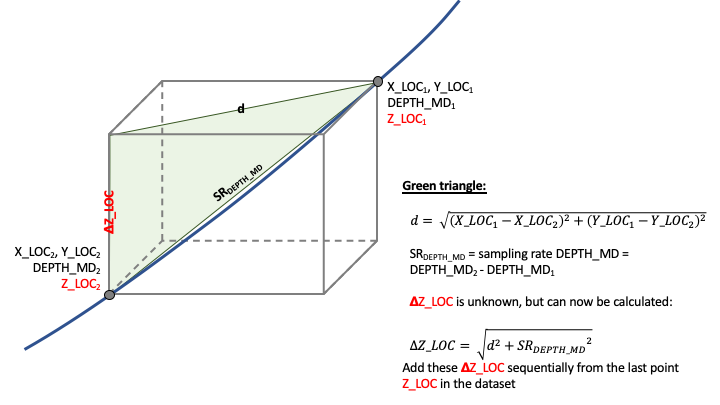

In [11]:
for w in df.WELL[~df.Z_LOC.notna()].unique():
    print(f'{w:>11} is missing... {len(df.X_LOC[df.WELL==w][df.Z_LOC[df.WELL==w].isna()]):4d} X_LOC rows and\
 {len(df.Y_LOC[df.WELL==w][df.Z_LOC[df.WELL==w].isna()]):4d} Y_LOC rows at missing Z_LOC rows\n\
 {13*" "} and has... {sum(df.X_LOC[df.WELL==w][df.Z_LOC[df.WELL==w].isna()].notna()):4d} X_LOC rows and\
 {sum(df.Y_LOC[df.WELL==w][df.Z_LOC[df.WELL==w].isna()].notna()):4d} Y_LOC rows at missing Z_LOC rows\n{"-"*83}')

16/11-1 ST3 is missing... 7374 X_LOC rows and 7374 Y_LOC rows at missing Z_LOC rows
               and has...    0 X_LOC rows and    0 Y_LOC rows at missing Z_LOC rows
-----------------------------------------------------------------------------------
  16/2-11 A is missing...    9 X_LOC rows and    9 Y_LOC rows at missing Z_LOC rows
               and has...    0 X_LOC rows and    0 Y_LOC rows at missing Z_LOC rows
-----------------------------------------------------------------------------------


#### For well 16/2-11 A only a small interval has missing Z_LOC data. Deviation is not expected to change much over a short interval, so get the difference between DEPTH_MD and Z_LOC just above the gap and us that constant to imputate Z_LOC values

In [12]:
well = '16/2-11 A'
df.loc[:,['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'dZ']][df.WELL==well].tail(25)

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,dZ
123148,2358.235199,475637.46875,6519188.5,-2043.375488,314.859712
123149,2358.387199,475637.53125,6519188.5,-2043.508911,314.878289
123150,2358.539199,475637.56250,6519188.5,-2043.642334,314.896866
123151,2358.691200,475637.59375,6519188.5,-2043.775757,314.915442
123152,2358.843200,475637.62500,6519189.0,-2043.909180,314.934019
123153,2358.995200,475637.65625,6519189.0,-2044.042603,314.952597
123154,2359.147200,475637.68750,6519189.0,-2044.176025,314.971175
123155,2359.299200,475637.71875,6519189.0,-2044.309448,314.989752
123156,2359.451200,475637.75000,6519189.0,-2044.442871,315.008329
123157,2359.603200,475637.78125,6519189.0,-2044.576294,315.026906


In [13]:
# get the minimum/maximum indices where Z_LOC is NaN for this well:
min_indx =min(df[df.WELL==well][df.Z_LOC.isna()].index)
max_indx =max(df[df.WELL==well][df.Z_LOC.isna()].index)

# get the average of the last 10 'ddZ' points above the gap:
avg_dZ = df.loc[min_indx-11:min_indx-1,'dZ'].mean() # note that indices are unique in the df - no need to filter for well

# calculate 'dZ' for the interval with missing Z_LOC:
df.loc[min_indx:max_indx,'Z_LOC']= -df.loc[min_indx:max_indx,'DEPTH_MD'] + avg_dZ

/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/harry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
df.loc[:,['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'dZ']][df.WELL==well].tail(25)

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,dZ
123148,2358.235199,475637.46875,6519188.5,-2043.375488,314.859712
123149,2358.387199,475637.53125,6519188.5,-2043.508911,314.878289
123150,2358.539199,475637.56250,6519188.5,-2043.642334,314.896866
123151,2358.691200,475637.59375,6519188.5,-2043.775757,314.915442
123152,2358.843200,475637.62500,6519189.0,-2043.909180,314.934019
123153,2358.995200,475637.65625,6519189.0,-2044.042603,314.952597
123154,2359.147200,475637.68750,6519189.0,-2044.176025,314.971175
123155,2359.299200,475637.71875,6519189.0,-2044.309448,314.989752
123156,2359.451200,475637.75000,6519189.0,-2044.442871,315.008329
123157,2359.603200,475637.78125,6519189.0,-2044.576294,315.026906


In [15]:
print(f'Original data:     {sum(df.Z_LOC_org.notna())} vs {len(df)}, or {len(df)-sum(df.Z_LOC_org.notna())} points missing')
print(f'Imputation data:   {sum(df.Z_LOC.notna())} vs {len(df)}, or {len(df)-sum(df.Z_LOC.notna())} points missing')
print(f'Extra data points: {(len(df)-sum(df.Z_LOC_org.notna()))-(len(df)-sum(df.Z_LOC.notna()))} (after imputation)')

Original data:     1159736 vs 1170511, or 10775 points missing
Imputation data:   1163137 vs 1170511, or 7374 points missing
Extra data points: 3401 (after imputation)


#### Now there is only 1 well left with missing Z_LOC data, but this one can not fixed as:
- A) the well i deviated in the section where Z_LOC is missing; 
- B) the missing Z_LOC section is very long and 
- C) X_LOC and Y_LOC are missing as well over that section. Hence Z_LOC can not be calculated geometrically.

In [16]:
df.WELL[~df.Z_LOC.notna()].unique()

array(['16/11-1 ST3'], dtype=object)